### fail이 일어나기 30일전의 데이터 추이를 확인하기 위해 평균을 plot으로 보는 작업

1. remove_null_columns(df), remove_single_value_columns(df) 함수 사용
2. failure disk 데이터들에 대해서, linear interpolate
3. 각 failure disk 별로 고장난 날짜 포함 30일에 대해서,timeseries clustering 하려고 함.
4. 처음 관측된 날짜와 fail이 일어난 날짜와의 차이가 29(30-1)보다 작으면, failure disk에서 제외시킴.
5. fail이 일어나기 이전 29일전 + fail이 일어난 날(총 30일) 데이터를 생성(=to_cluster_data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import mglearn

In [2]:
data = pd.read_csv('../../ssd_data/combined_by_diskmodel/combined_MB1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
del(data['level_0'])
data

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,r_244,n_245,r_245,n_175,r_175,n_232,r_232,label,n_211,r_211
0,10005,20190101,MB1,NaN,NaN,100.0,0.0,99.0,4600.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,39138,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13256.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
2,3918,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13305.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
3,39187,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
4,39189,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7132648,27627,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132649,27631,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132650,27676,20190630,MB1,NaN,NaN,100.0,0.0,96.0,18069.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132651,27586,20190630,MB1,NaN,NaN,100.0,0.0,98.0,8476.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN


In [12]:
# null값이 있는 열을 제거하는 코드
def remove_null_columns(df):
    # null인 컬럼을 확인하고, 모든 값이 null인 컬럼을 찾습니다.
    null_columns = df.columns[df.isnull().all()]
    
    # 모든 값이 null인 컬럼을 DataFrame에서 제거합니다.
    df = df.drop(null_columns, axis=1)
    
    return df
# 하나의 unique한 값으로만 이루어진 컬럼을 제거하는 코드
def remove_single_value_columns(df):
    single_value_cols = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values == 1:
            single_value_cols.append(col)

    df_filtered = df.drop(single_value_cols, axis=1)
    return df_filtered


In [13]:
data = remove_null_columns(data)
data = remove_single_value_columns(data)

failed된 disk_id중에서 첫 관측에서 마지막 관측의 결측치 채우기<br>
interpolate-linear

In [14]:
selected_disk_ids = data[data['label']==1]['disk_id'].unique()

dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data = interpolated_data.reset_index()  # 인덱스 재설정
interpolated_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,17909.0,99.0,2.0,97.0,12819.0,99.0,19.0,97.0,155.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.761304e+11,99.0,3.422788e+11,1.0
1,2019-01-02,17909.0,99.0,2.0,97.0,12843.0,99.0,19.0,97.0,155.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.774871e+11,99.0,3.432220e+11,0.0
2,2019-01-03,17909.0,99.0,2.0,97.0,12867.0,99.0,19.0,97.0,156.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.790559e+11,99.0,3.467700e+11,0.0
3,2019-01-04,17909.0,99.0,2.0,97.0,12891.0,99.0,19.0,97.0,156.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.805626e+11,99.0,3.477830e+11,0.0
4,2019-01-05,17909.0,99.0,2.0,97.0,12915.0,99.0,19.0,97.0,157.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.819720e+11,99.0,3.512526e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [15]:
selected_disk_model_1 = interpolated_data['disk_id'].unique()

to_delete_id =[]
for disk_id in selected_disk_model_1:
    disk_data = interpolated_data[interpolated_data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    start_index = disk_data.index.min()

    if(failed_index - start_index) < 29:
        to_delete_id.append(disk_id)

# failed_disk_index에 해당하는 행들을 제거
data = interpolated_data[~interpolated_data['disk_id'].isin(to_delete_id)]
data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
4148,2019-01-01,41400.0,100.0,0.0,97.0,12694.0,99.0,13.0,99.0,55.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.812450e+11,99.0,1.329623e+11,0.0
4149,2019-01-02,41400.0,100.0,0.0,97.0,12718.0,99.0,13.0,99.0,55.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.813687e+11,99.0,1.333035e+11,0.0
4150,2019-01-03,41400.0,100.0,0.0,97.0,12742.0,99.0,13.0,99.0,56.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.815201e+11,99.0,1.336394e+11,0.0
4151,2019-01-04,41400.0,100.0,0.0,97.0,12766.0,99.0,13.0,99.0,56.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.816743e+11,99.0,1.339799e+11,0.0
4152,2019-01-05,41400.0,100.0,0.0,97.0,12790.0,99.0,13.0,99.0,56.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.818216e+11,99.0,1.343434e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [16]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(244, 1)

In [17]:
to_cluster_data = pd.DataFrame()

for disk_id in selected_disk_model_1['disk_id'].unique():
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    before_9day_index = failed_index - 29

    to_cluster = disk_data.iloc[before_9day_index:failed_index+1, :]
    to_cluster_data = pd.concat([to_cluster_data,to_cluster],axis=0)
    
to_cluster_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
54,2019-02-24,470.0,99.0,4.0,96.0,15574.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.718806e+09,0.0
55,2019-02-25,470.0,99.0,4.0,96.0,15598.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.720226e+09,0.0
56,2019-02-26,470.0,99.0,4.0,96.0,15622.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.721518e+09,0.0
57,2019-02-27,470.0,99.0,4.0,96.0,15646.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.722888e+09,0.0
58,2019-02-28,470.0,99.0,4.0,96.0,15670.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.724136e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0
80,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0
81,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0
82,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0


In [18]:
#10일씩 제대로 묶였는지 확인 => ok
to_cluster_data[to_cluster_data['disk_id']==470]

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
54,2019-02-24,470.0,99.0,4.0,96.0,15574.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.718806e+09,0.0
55,2019-02-25,470.0,99.0,4.0,96.0,15598.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.720226e+09,0.0
56,2019-02-26,470.0,99.0,4.0,96.0,15622.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.721518e+09,0.0
57,2019-02-27,470.0,99.0,4.0,96.0,15646.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.722888e+09,0.0
58,2019-02-28,470.0,99.0,4.0,96.0,15670.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.724136e+09,0.0
59,2019-03-01,470.0,99.0,4.0,96.0,15694.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.725311e+09,0.0
60,2019-03-02,470.0,99.0,4.0,96.0,15718.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.726483e+09,0.0
61,2019-03-03,470.0,99.0,4.0,96.0,15742.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.727686e+09,0.0
62,2019-03-04,470.0,99.0,4.0,96.0,15766.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.729018e+09,0.0
63,2019-03-05,470.0,99.0,4.0,96.0,15790.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.730343e+09,0.0


In [22]:
mean_data = to_cluster_data.drop(['index','disk_id','label'],axis=1)
mean_data=mean_data.reset_index()
mean_data = mean_data.drop(['index'],axis=1)
mean_data

Index(['n_5', 'r_5', 'n_9', 'r_9', 'n_12', 'r_12', 'n_177', 'r_177', 'n_180',
       'r_180', 'n_181', 'r_181', 'n_182', 'r_182', 'n_183', 'r_183', 'n_184',
       'r_184', 'n_187', 'r_187', 'n_190', 'r_190', 'n_194', 'r_194', 'n_195',
       'r_195', 'n_199', 'r_199', 'n_241', 'r_241', 'n_242', 'r_242'],
      dtype='object')

In [25]:
result = mean_data.groupby(mean_data.index % 30).mean()

# 결과를 출력합니다.
result

,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,n_180,r_180,...,n_194,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242
0,99.750000,1.098361,96.418911,14988.733926,99.0,21.775118,96.426230,222.029993,99.750000,6511.008197,...,70.979437,29.020563,199.172131,941.262295,99.905738,0.422131,99.004098,6.829884e+11,98.991803,4.909313e+11
1,99.745902,1.106557,96.414780,15012.608521,99.0,21.777923,96.426230,222.391580,99.745902,6511.000000,...,70.929320,29.070680,199.172131,941.262295,99.905738,0.422131,99.004098,6.838989e+11,98.991803,4.917310e+11
2,99.704918,3.680328,96.414748,15036.479017,99.0,21.780729,96.418033,222.693741,99.704918,6508.426230,...,71.028793,28.971207,199.172131,941.262295,99.905738,0.422131,99.004098,6.846085e+11,98.991803,4.924073e+11
3,99.704918,3.680328,96.414715,15060.400557,99.0,21.782789,96.418033,222.962370,99.704918,6508.426230,...,71.028042,28.971958,199.172131,941.262295,99.905738,0.422131,99.004098,6.852488e+11,98.991803,4.930690e+11
4,99.704918,3.680328,96.414683,15084.313900,99.0,21.784850,96.405738,223.200261,99.704918,6508.426230,...,71.080571,28.919429,199.172131,941.262295,99.905738,0.422131,99.004098,6.858838e+11,98.991803,4.937927e+11
5,99.704918,3.680328,96.410552,15108.053063,99.0,21.791009,96.405738,223.446349,99.704918,6508.426230,...,70.930230,29.069770,199.172131,941.262295,99.901639,0.579918,99.000000,6.865202e+11,98.991803,4.944632e+11
6,99.704918,3.688525,96.410519,15131.837308,99.0,21.797167,96.401639,223.710879,99.704918,6508.418033,...,71.046283,28.953717,199.172131,941.262295,99.897541,0.737705,98.995902,6.871590e+11,98.991803,4.951329e+11
7,99.704918,3.688525,96.410487,15155.758847,99.0,21.799228,96.401639,223.967213,99.704918,6508.418033,...,71.070123,28.929877,199.172131,941.262295,99.897541,0.737705,98.995902,6.877929e+11,98.991803,4.958855e+11
8,99.704098,3.690164,96.410454,15179.748569,99.0,21.799425,96.401639,224.237705,99.704098,6508.416393,...,70.907375,29.092625,199.172131,941.262295,99.897541,0.741803,98.995902,6.884217e+11,98.991803,4.965467e+11
9,99.703279,3.691803,96.406323,15203.742389,99.0,21.799623,96.401639,224.454918,99.703279,6508.414754,...,71.047907,28.952093,199.172131,941.262295,99.897541,0.741803,98.995902,6.890543e+11,98.991803,4.972097e+11


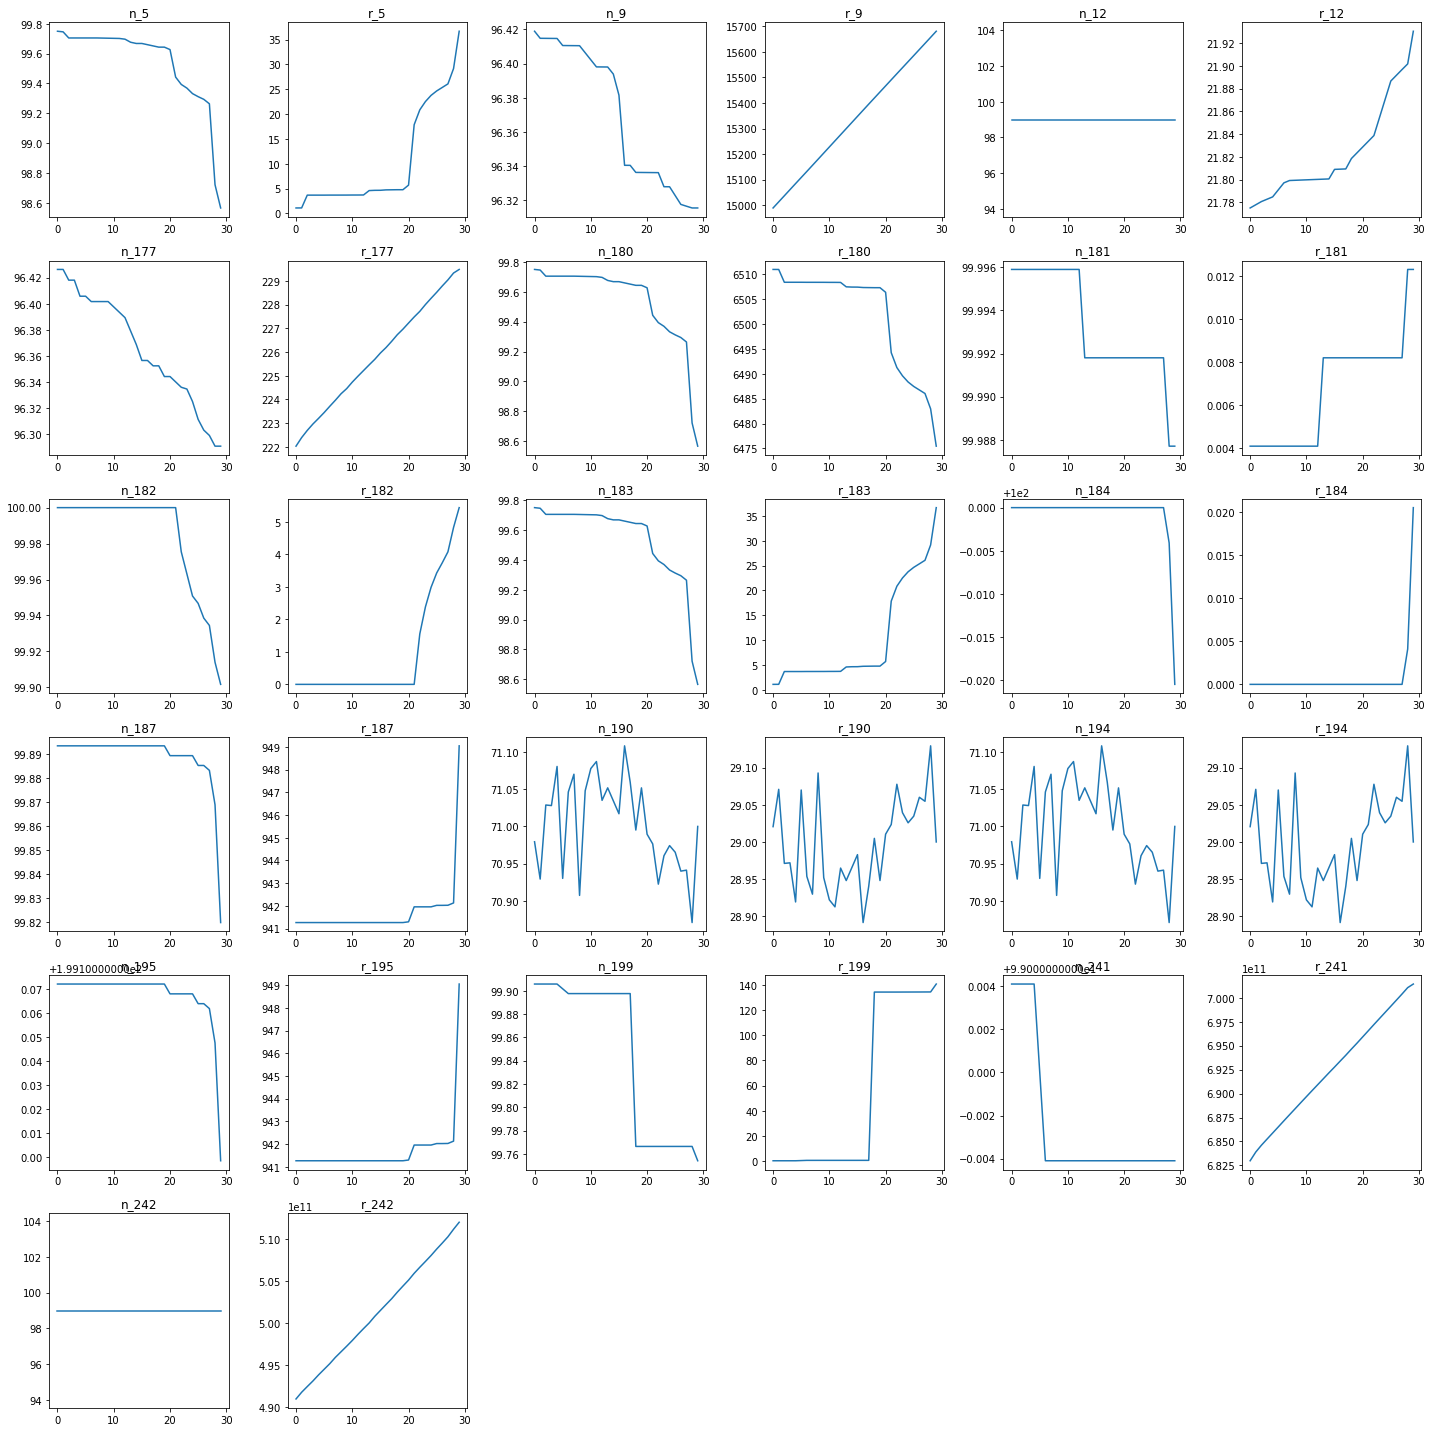

In [26]:
import matplotlib.pyplot as plt
import math

# 전체 subplot의 행과 열의 수를 결정합니다.
n = len(result.columns)
ncols = 8
nrows = math.ceil(n / ncols)

# figsize를 조절하여 그래프의 크기를 조정할 수 있습니다.
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, column in enumerate(result.columns):
    # 현재 subplot의 행과 열의 위치를 결정합니다.
    row = i // ncols
    col = i % ncols

    # 해당 위치에 line plot을 그립니다.
    axs[row, col].plot(result[column])
    axs[row, col].set_title(column)

# 남는 subplot이 있을 경우 이를 비활성화합니다.
for i in range(n, nrows*ncols):
    row = i // ncols
    col = i % ncols
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()